# Step 0: Get the data

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

# If you'd like to restore warnings later use the following line
# warnings.filterwarnings("default")
import pandas as pd
import numpy as np

# Simulate data following the causal graph
np.random.seed(42)
N = 1000
Z = np.random.normal(0, 1, N)
X = 80 * Z + np.random.normal(0, 1, N)
Y = X + 30 * Z + np.random.normal(0, 1, N)

data = pd.DataFrame({'X': X, 'Y': Y, 'Z': Z})

# Step 1: Construct the graph!

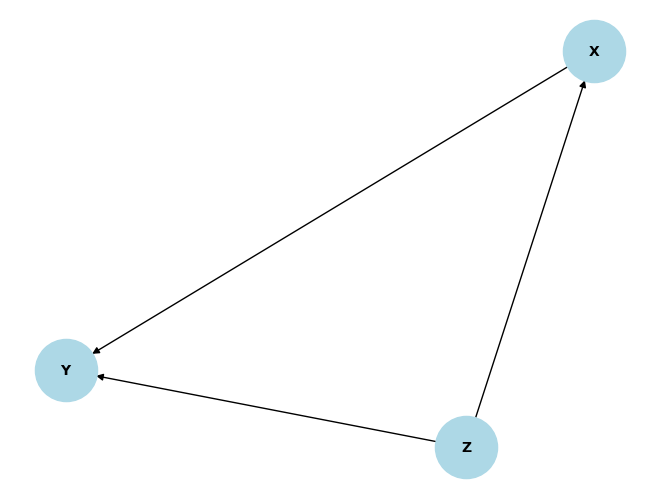

In [2]:
import networkx as nx
from dowhy import CausalModel
import matplotlib.pyplot as plt

# Create a DAG using NetworkX
causal_graphNX = nx.DiGraph()

# Add nodes (variables)
#causal_graphNX.add_nodes_from(['X', 'Y', 'Z'])

# Add edges (causal effects)
#causal_graphNX.add_edges_from([('X', 'Y'), ('Z', 'X'), ('Z', 'Y')])

causal_graphNX = nx.DiGraph([('X', 'Y'), ('Z', 'X'), ('Z', 'Y')])


# Visualize the graph
nx.draw(causal_graphNX, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold')
plt.show()

In [3]:
causal_graph_dot = """
digraph {
    Z -> X;
    Z -> Y;
    X -> Y;
}
"""

#causal_graph__noconfounder_dot = """
#digraph {
#    X -> Y;
#}
#"""
causal_graph_daggitty = """digraph {
bb="0,0,1,1"
X [exposure,pos="0.131,0.766"]
Y [outcome,pos="0.358,0.774"]
Z [pos="0.237,0.498"]
X -> Y
Z -> X
Z -> Y
}"""



# Step 2: Identification

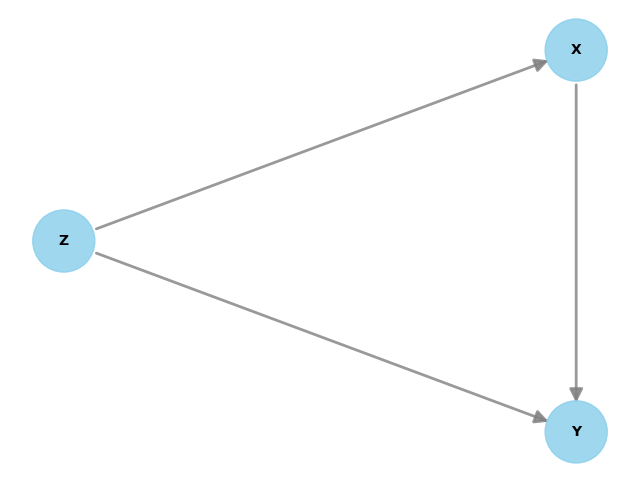

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,U) = P(Y|X,Z)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [4]:
model = CausalModel(
    data=data,
    treatment='X',
    outcome='Y',
    graph=causal_graphNX#causal_graph_daggitty.replace("\n", " ")
)

# View the model
model.view_model()

## Identify the causal effect
identified_estimand = model.identify_effect()
print(identified_estimand)

# Step 3: Estimtation

In [5]:
## Estimate the causal effect
estimate = model.estimate_effect(identified_estimand,
                                method_name="backdoor.linear_regression")

print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|Z])
d[X]        
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,Z,U) = P(Y|X,Z)

## Realized estimand
b: Y~X+Z
Target units: ate

## Estimate
Mean value: 0.9898226578753025



# Step 4: Refutation

## Method-1

**Random Common Cause**:
Adds randomly drawn covariates to data and re-runs the analysis to see if the causal estimate changes or not. If our assumption was originally correct then the causal estimate shouldn’t change by much.

In [7]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a random common cause
Estimated effect:0.9898226578753025
New effect:0.9898582812823803
p value:0.98



# Method-2
**Placebo Treatment Refuter**:
Randomly assigns any covariate as a treatment and re-runs the analysis. If our assumptions were correct then this newly found out estimate should go to 0.

In [8]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:0.9898226578753025
New effect:0.0
p value:1.0



# Method-3
**Data Subset Refuter**:
Creates subsets of the data(similar to cross-validation) and checks whether the causal estimates vary across subsets. If our assumptions were correct there shouldn’t be much variation.

In [9]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

Refute: Use a subset of data
Estimated effect:0.9898226578753025
New effect:0.9907914055855889
p value:0.8999999999999999



Here is a reference to the interpretation of the [refuters in the DoWhy-Library](https://causalwizard.app/inference/article/bootstrap-refuters-dowhy).